In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Đọc file csv và gắng index với Price
df = pd.read_csv('/content/drive/MyDrive/StockData/GAS.csv')
df=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for RNN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 4s 153ms/step - loss: 0.2867 - val_loss: 0.0144
Epoch 2/100
11/11 [==============================] - 1s 66ms/step - loss: 0.0224 - val_loss: 0.0531
Epoch 3/100
11/11 [==============================] - 1s 65ms/step - loss: 0.0087 - val_loss: 0.0047
Epoch 4/100
11/11 [==============================] - 1s 64ms/step - loss: 0.0040 - val_loss: 0.0087
Epoch 5/100
11/11 [==============================] - 1s 64ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 6/100
11/11 [==============================] - 1s 65ms/step - loss: 0.0023 - val_loss: 0.0062
Epoch 7/100
11/11 [==============================] - 1s 63ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 8/100
11/11 [==============================] - 1s 69ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 9/100
11/11 [==============================] - 1s 69ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 10/100
11/11 [==============================] - 1s 61ms/step - loss: 0.0019 - val_loss: 0.004

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 31ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# Chia train test lại
train_data1 = df[:train_size]
test_data1 = df[train_size:train_size+test_size]
val_data1 = df[train_size+test_size:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)


In [ ]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 9671.26253203254
Testing RMSE: 13714.768892406997
Validation MAPE: 8.00101459165009
Testing MAPE: 11.141893480412826
Validation MAE: 8395.309389880953
Testing MAE: 10849.461320863747


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=66
i=0
while(i<30):

    if(len(temp_input)>66):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.51523095]
67
1 day input [0.66760733 0.66107497 0.65062319 0.66107497 0.67936558 0.69112383
 0.69373677 0.70810797 0.70288208 0.69373677 0.66238144 0.65062319
 0.64147788 0.64409083 0.64017141 0.63494552 0.63363905 0.62841316
 0.65062319 0.63886494 0.63363905 0.62841316 0.63494552 0.62710669
 0.62710669 0.6218808  0.61796138 0.59575135 0.60097724 0.59967077
 0.60228371 0.57746074 0.56570249 0.5604766  0.54479893 0.55002482
 0.54218599 0.51213713 0.49776593 0.51605654 0.50037888 0.50821771
 0.49776593 0.49645946 0.51213713 0.52520185 0.5134436  0.50037888
 0.50429829 0.50037888 0.50299182 0.49645946 0.51083066 0.53565363
 0.53304068 0.5134436  0.50429829 0.53304068 0.51997596 0.52128243
 0.50952418 0.50821771 0.49776593 0.49776593 0.52389538 0.51523095]
1 day output [[0.52127147]]
2 day input [0.66107497 0.65062319 0.66107497 0.67936558 0.69112383 0.69373677
 0.70810797 0.70288208 0.69373677 0.66238144 0.65062319 0.64147788
 0.64409083 0.64017141 0.63494552 0.63363905 0.62841316 0.65

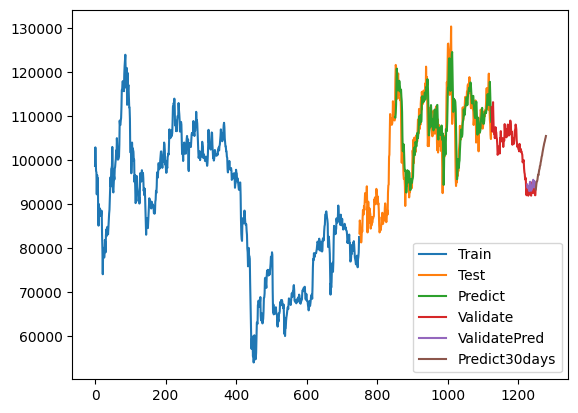

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()